In [2]:
%%capture
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from tensorflow.keras import layers, utils, losses, models as mds, optimizers
from visualkeras import layered_view

if imp.find_loader('aggdraw'): import aggdraw
if imp.find_loader('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers

2022-03-16 14:37:37.560988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 14:37:37.561095: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
IMG_SIZE = 264
N_CLASSES = 102

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block_0 (Sequential)      (None, 132, 132, 32  1024        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv_block_1 (Sequential)      (None, 132, 132, 32  9376        ['conv_block_0[0][0]']           
                                )                                                           

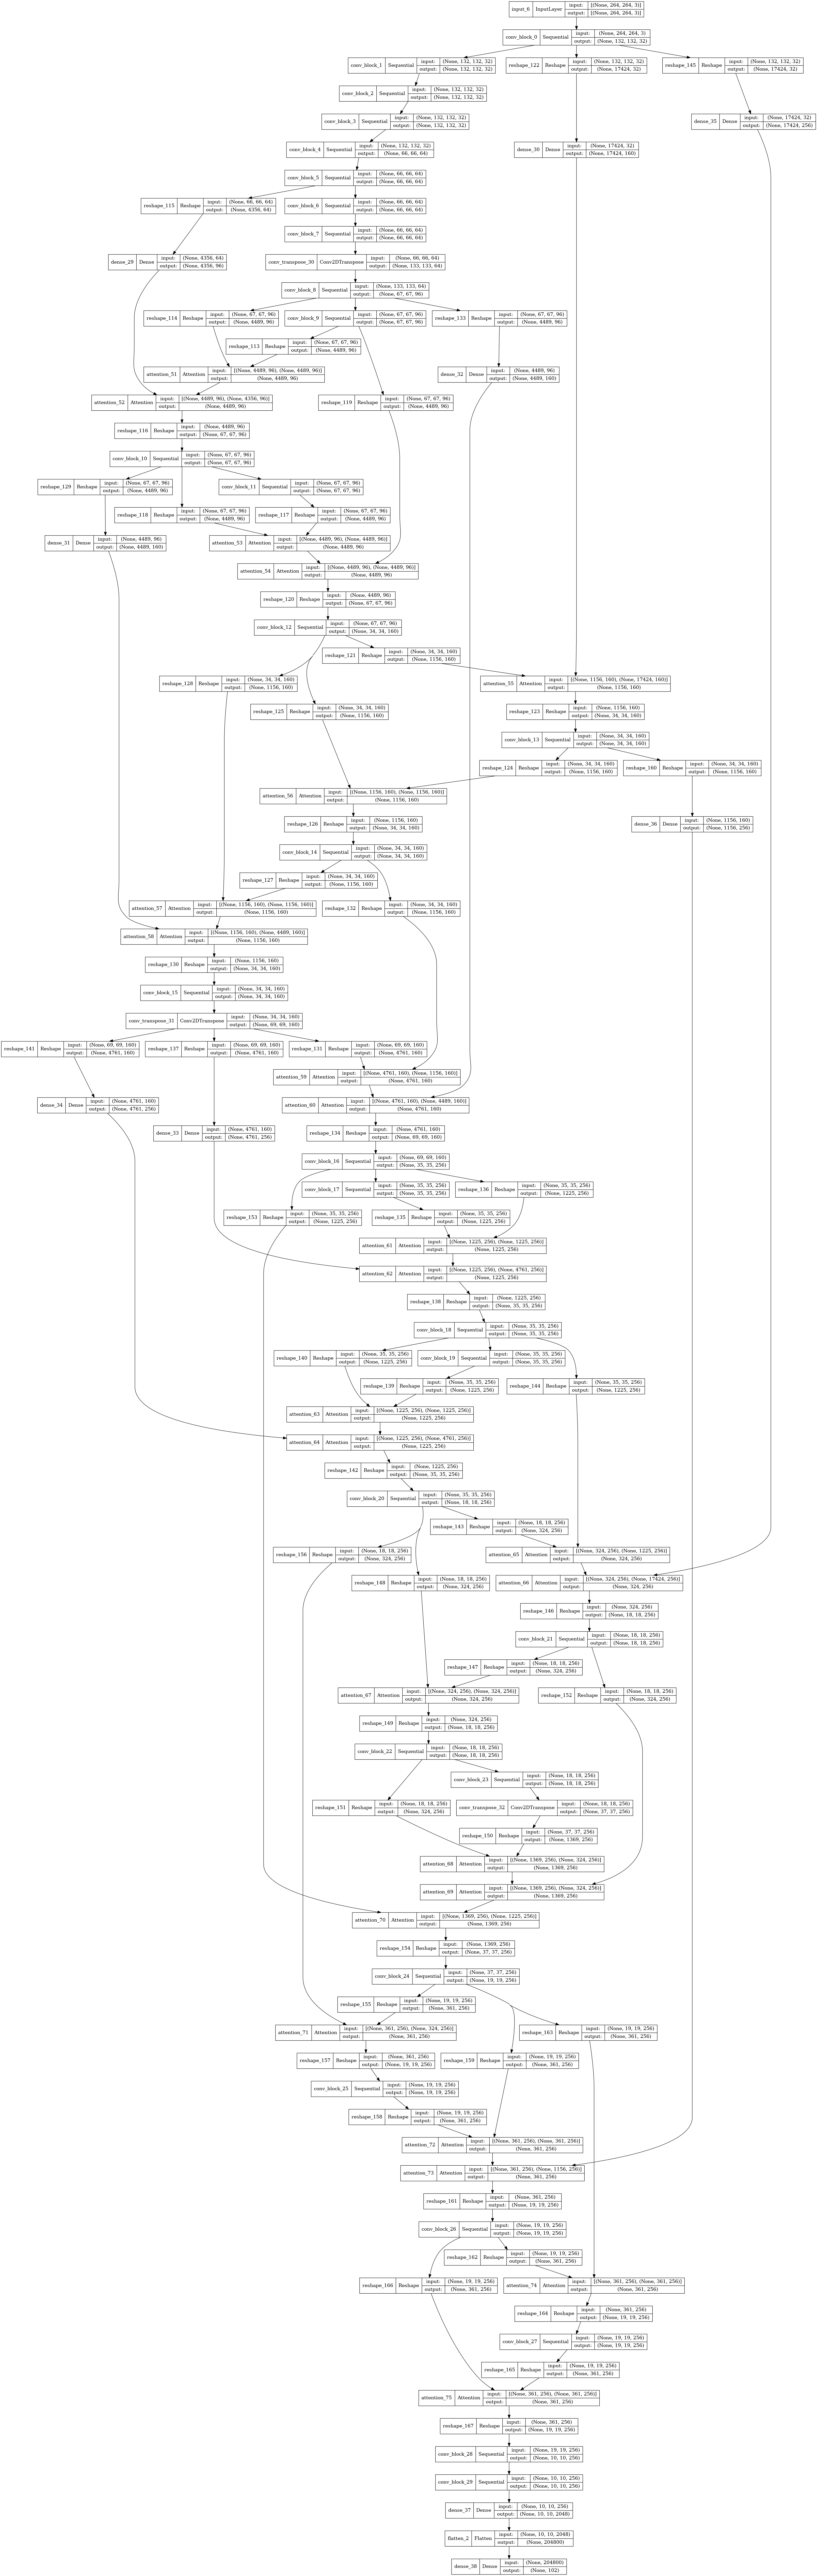

In [9]:
def sic_block(input_tensor, filters, strides, padding, activation):
    def variant_dims(size):
        n_variants = ceil(log(ceil(sqrt(size)), pi))
        return list(map(lambda x: 3**x, range(1, n_variants+1)))

    def make_layer(size):
        kwargs = dict(strides=strides, padding=padding)
        return layers.Conv2D(filters, size, **kwargs)

    size = min(input_tensor.shape[1:-1])
    variants = variant_dims(size)
    conv_layers = map(make_layer, variants)
    conv_outputs = list(map(lambda x: x(input_tensor), conv_layers))
    merged = tf.concat(conv_outputs, axis=-1)
    normalized = layers.BatchNormalization()(merged)
    output = layers.Activation(activation)(normalized)

    return output

conv_id = -1

def increment_conv_id():
    global conv_id
    conv_id += 1

    return conv_id

def conv_block(filters, **kwargs):
    return tf.keras.Sequential([
            layers.Conv2D(filters, 3, **kwargs),
            layers.BatchNormalization(),
        ],
        name='conv_block_' + str(increment_conv_id()))

def attentive_merge(q, v):
    v = layers.Dense(q.shape[-1])(v) if v.shape[-1] != q.shape[-1] else v
    return layers.Attention()([q, v])

def multi_level_merge(q, vs):
    format = lambda t: layers.Reshape([-1, t.shape[-1]])(t)
    unformat = lambda t,s: layers.Reshape(s[1:])(t)

    # output = reduce(lambda y,x: layers.Attention()([y, format(x)]), qs, format(v))
    output = reduce(lambda y,x: attentive_merge(y, format(x)), vs, format(q))

    v = unformat(output, q.shape)
    return v

class Fibo(object):
    def __init__(self, first, second, limit=None):
        self.first = first
        self.second = second
        self.limit = limit
    
    def next(self):
        v = self.first + self.second
        limit_cond = self.limit and v < self.limit
        self.first, self.second = (self.second, v) if limit_cond else (self.second, self.limit)
        return self.second
    
    def get(self):
        return self.second

def assemble_backbone(input_tensor, depth, skip_rates, skip_start_depth,
    heat=1, chill=1, reheat=8,
    min_channels=32, max_channels=1024
):
    # Heat indicate conv down. Chill follows heat convs which preserves the spatial dimensions.
    # Reheat is conv up operation. It is followed by chill convs.
    channel_fibo = Fibo(0, min_channels, max_channels)
    # channel_fn = lambda x: min(max(min_channels*2**(x//(heat+chill)-1), min_channels), max_channels)
    # conf_fn = lambda x: (2, channel_fn(x)) if x%(heat+chill) == 0 else (1, channel_fn(x))
    channel_fn = lambda: min(channel_fibo.next(), max_channels)
    conf_fn = lambda x: (2, channel_fn()) if x%(heat+chill) == 0 else (1, channel_fibo.get())

    # strides = list(map(lambda x: 2 if x%(heat+chill) == 0 else 1, range(depth)))
    confs = list(map(conf_fn, range(depth)))

    # print(confs)
    # return

    # Create Convolution Blocks
    kwargs = dict(padding='same', activation='relu')
    blocks = list(map(lambda x: conv_block(x[1], strides=x[0], **kwargs), confs))
    block_outputs = [None] * len(blocks)

    # Compute skip connections
    skip_levels = list(map(lambda sr: list(range(0, depth, sr)), skip_rates))
    skip_connections = [[] for _ in range(depth)]

    for sl in skip_levels:
        for x in range(1, len(sl)):
            skip_connections[sl[x]].append(sl[x-1])

    def join_skips(idx, skips):
        skip_outputs = list(map(lambda x: block_outputs[x], skips))
        block_input =  multi_level_merge(block_outputs[idx-1], skip_outputs)
        return blocks[idx](block_input)
    
    def apply_reheat(idx, x):
        filters, name = x.shape[-1], 'conv_transpose_' + str(increment_conv_id())
        x = layers.Conv2DTranspose(filters, 3, strides=2, name=name)(x)
        block_outputs[idx-1] = x
        return x
    
    for idx, block in enumerate(blocks):
        skips = skip_connections[idx]

        # Deconv to increase dimensionality
        reheat_cond = reheat and idx and not idx%reheat
        input_tensor = apply_reheat(idx, input_tensor) if reheat_cond else input_tensor

        join_cond = skips and idx >= skip_start_depth
        input_tensor = join_skips(idx, skips) if join_cond else block(input_tensor)
        block_outputs[idx] = input_tensor
    
    return input_tensor
    
def create_model(depth=60, skips=[2, 3, 5, 8, 13, 21, 34, 55], skip_start_depth=9, **kwargs):
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = assemble_backbone(inp, depth, skips, skip_start_depth, **kwargs)
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Flatten()(x)
    output = layers.Dense(N_CLASSES, activation='softmax')(x)

    m = tf.keras.Model(inputs=inp, outputs=output)
    optimizer = optimizers.Nadam()

    m.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='accuracy')

    return m

kwargs = dict(heat=1, chill=3, min_channels=32, max_channels=256)
model = create_model(depth=30, skips=[2, 3, 5, 8, 13, 21], skip_start_depth=10, **kwargs)
model.summary()
utils.plot_model(model, show_shapes=True)

In [29]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block_0 (Sequential)      (None, 132, 132, 64  2048        ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 conv_block_1 (Sequential)      (None, 132, 132, 64  37184       ['conv_block_0[0][0]']           
                                )                                                           

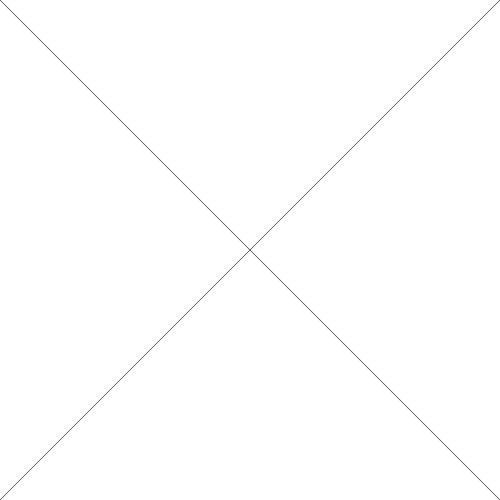

In [42]:
class Fibo(object):
    def __init__(self, first, second):
        self.first = first
        self.second = second
    
    def next(self):
        v = self.first + self.second
        self.first, self.second = self.second, v
        return v
    
    def get(self):
        return self.second

fibo = Fibo(1, 1)
fibo.next(), fibo.next(), fibo.get()

(2, 3, 3)